In [26]:
import os
import json
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import metrics
import statistics

import matplotlib
%matplotlib inline
import math
from matplotlib import pyplot as plt
from keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Concatenate, Flatten, MaxPooling1D
from keras.models import Model
from itertools import islice
from scipy import stats

plt.rcParams['figure.figsize'] = (8,6)

In [2]:
json_file_dir = "G:\\Dev\\trees_gnps"
gnps_dir = "G:\\Dev\\Data\\GNPS"
fragments_occurences = "G:\\Dev\\fragment_occurences.csv"
losses_occurences = "G:\\Dev\\losses_occurences.csv"

fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"

In [3]:
fragments_df = pd.read_csv(fragments_occurences, names=["formula", "occurences"])
fragments_df = fragments_df.set_index("formula")
losses_df = pd.read_csv(losses_occurences, names=["formula", "occurences"])
losses_df = losses_df.set_index("formula")

In [4]:
print(fragments_df.index)

Index(['C9H6', 'C8H8', 'C8H6', 'C9H8', 'C10H8', 'C8H8O', 'C7H6', 'C11H8',
       'C7H6O', 'C9H10',
       ...
       'C3H3NS', 'C4H7N3O', 'C5H8ClN5', 'C4H6ClN3', 'CClN', 'C3H2N2',
       'C7H3Cl2NO', 'C3O', 'HO2P', 'C4H11O3PS'],
      dtype='object', name='formula', length=4616)


In [5]:
losses_df.index = [index + "_loss" for index in losses_df.index]
print(losses_df.index)
combined_index = fragments_df.index.union(losses_df.index)
print(combined_index)

Index(['CO_loss', 'H2O_loss', 'C2H2_loss', 'CH3_loss', 'CHN_loss', 'CH4_loss',
       'H3N_loss', 'H2_loss', 'C2H4_loss', 'C2H2O_loss',
       ...
       'C3H8S_loss', 'OP_loss', 'CH2N3_loss', 'C7H7NO3_loss', 'O2P_loss',
       'C2H5NOS_loss', 'C10H4N3_loss', 'C9H17O3_loss', 'C3H7N4_loss',
       'C4H6NO2_loss'],
      dtype='object', length=892)
Index(['BrH_loss', 'Br_loss', 'C10', 'C10H10', 'C10H10ClN', 'C10H10ClNO',
       'C10H10ClNO2', 'C10H10F2O2', 'C10H10FN', 'C10H10N',
       ...
       'O2_loss', 'O3S_loss', 'O3_loss', 'O4_loss', 'O5_loss', 'OP_loss',
       'OS_loss', 'O_loss', 'S2_loss', 'S_loss'],
      dtype='object', length=5508)


In [6]:
def read_tree(filepath, fragment_formula):
    fragments = {}
    
    with open(filepath, 'r') as f:
        data = json.load(f)

    for fragment in data['fragments']:
        if fragment['molecularFormula'] in fragment_formula:
            if "intensity" in fragment:
                fragments[(fragment['molecularFormula'])] = float(fragment['intensity'])
     
    return fragments

def read_tree_with_losses(filepath, fragment_formula, losses_formula):
    fragments = {}
    losses = {}
    all_fragments = {}
    
    with open(filepath, 'r') as f:
        data = json.load(f)

    for fragment in data['fragments']:
        if "intensity" in fragment:
            all_fragments[(fragment['molecularFormula'])] = float(fragment['intensity'])
            if fragment['molecularFormula'] in fragment_formula:
                fragments[(fragment['molecularFormula'])] = float(fragment['intensity'])

    for loss in data['losses']:
        loss_index = loss['molecularFormula'] + "_loss"
        if loss_index in losses_formula and loss["source"] in all_fragments and loss["target"] in all_fragments:
            losses[loss_index] = (all_fragments[loss["source"]] + all_fragments[loss["target"]]) /2 
                
    return fragments, losses

In [7]:
def dict_is_empty(sample_dict):
    return len(sample_dict.keys()) == 0

def get_mol_names(path_dir):
    return [file[:-3] for file in os.listdir(path_dir)]

def load_tree(path_dir, fragments_formula):
    mol_ids = get_mol_names(path_dir)
    intensities = pd.DataFrame(0.0, index=mol_ids, columns=fragments_formula, dtype=float)
    for file in os.listdir(path_dir):
        mol_name = file[:-3]
        tree_path = json_file_dir + os.sep + mol_name + ".json"
        fragments = read_tree(tree_path, fragments_formula)
        if dict_is_empty(fragments):
            intensities.drop([mol_name], inplace=True)
        else:
            for fragment, intensity in fragments.items():
                intensities.at[mol_name, fragment] = float(intensity)
            if np.amax(intensities.loc[mol_name].values) > 0:
                intensities.loc[mol_name] = intensities.loc[mol_name].div(np.amax(intensities.loc[mol_name].values)).mul(999)
            else:
                intensities.drop([mol_name], inplace=True) # drop those that has 0 rows
    return intensities

def load_tree_with_losses(path_dir, combined_index):
    mol_ids = get_mol_names(path_dir)
    intensities = pd.DataFrame(0.0, index=mol_ids, columns=combined_index, dtype=float)
    for file in os.listdir(path_dir):
        mol_name = file[:-3]
        tree_path = json_file_dir + os.sep + mol_name + ".json"
        fragments, losses = read_tree_with_losses(tree_path, fragments_df.index, losses_df.index)
        if dict_is_empty(fragments) or dict_is_empty(losses):
            intensities.drop([mol_name], inplace=True)
        else:
            for fragment, intensity in fragments.items():
                intensities.at[mol_name, fragment] = float(intensity)
            for fragment, intensity in losses.items():
                intensities.at[mol_name, fragment] = float(intensity)
            intensities.loc[mol_name] = intensities.loc[mol_name].div(np.amax(intensities.loc[mol_name].values)).mul(999)
    return intensities


In [8]:
# Load a master file containing CDK fingerprints for all molecules.
# Each molecules CDK bit set is added as a 320 element array to a Pandas dataframe.
def load_fingerprints_master(path, number_of_rows=0):
    BITS = 307  # Total number of bits in fingerprint

    fp_all = np.loadtxt(path, dtype="U25", skiprows=number_of_rows) # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0]) # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    fingerprints = pd.DataFrame(0, index = fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in fp_all:
        fingerprints.at[row[0], int(row[1])] = int(row[2])

    # Convert populated dataframe into a numpy array for use as output by neural networks.
    return fingerprints

# Load the names of all substructures included in the CDK fingerprint in the correct order
# This is used for boxplots, when performance metrics for individual substructures are calculated.
def load_fingerprint_legend():
    fingerprint_legend = []
    # Open file containing substructure names.
    with open(fingerprints_names_path, 'r') as f:
        # Add each name to the list of substructure names.
        lines = list(islice(f, 0, None))
        for line in lines:
            fingerprint_legend.append(line[:-1])
    return fingerprint_legend


In [9]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD

def baseline_model(x_train_formula, x_train_fingerprints):
    class_model = Sequential()
    class_model.add(Dense(2500, input_dim=x_train_formula.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(1200,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(600,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(x_train_fingerprints.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return class_model

In [10]:
def compute_auc(indexes, true, pred):
    auc_scores = []
    
    for i, index in enumerate(indexes):
        nonzero_vals = np.count_nonzero(true[:, i]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[:, i].size: # If there are no 1s or no 0s, can't compute.
            fp_true = true[:, i]
            fp_pred = pred[:, i]
            score = metrics.roc_auc_score(fp_true, fp_pred)
            auc_scores.append((index, score))
        else:
            auc_scores.append((index, 0.0))
            
    print("Compute AUC done")
    return auc_scores

def compute_f1(indexes, true, pred):
    f1_scores = []
    
    for i, index in enumerate(indexes):
        nonzero_vals = np.count_nonzero(true[:, i]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[:, i].size: # If there are no 1s or no 0s, can't compute.
            fp_true = true[:, i]
            fp_pred = pred[:, i]
            score = metrics.f1_score(fp_true, fp_pred, average='micro')
            f1_scores.append((index, score))
        else:
            f1_scores.append((index, 0.0))
            
    print("Compute F1 done")
    return f1_scores

In [11]:
def get_tree_training(fingerprints, train):
    train.sort_index(inplace=True)
    x_train_formula = np.log(train.values+1)
    
    train_fingerprints = fingerprints[fingerprints.index.isin(train.index)]
    train_fingerprints.sort_index(inplace=True)
    x_train_fingerprints = train_fingerprints.values
    
    return x_train_formula, x_train_fingerprints

def get_tree_validation(fingerprints, validate):
    validate.sort_index(inplace=True)
    x_validate_formula = np.log(validate.values+1)
    
    validate_fingerprints = fingerprints[fingerprints.index.isin(validate.index)]
    validate_fingerprints.sort_index(inplace=True)
    x_validate_fingerprints = validate_fingerprints.values
    
    return x_validate_formula, x_validate_fingerprints

def get_tree_test(fingerprints, test):
    test.sort_index(inplace=True)
    x_test_formula = np.log(test.values+1)
    
    test_fingerprints = fingerprints[fingerprints.index.isin(test.index)]
    test_fingerprints.sort_index(inplace=True)
    x_test_fingerprints = test_fingerprints.values
    
    return x_test_formula, x_test_fingerprints

def get_tree_loss_training(fingerprints, tree_with_loss, train):
    train_tree = tree_with_loss[tree_with_loss.index.isin(train.index)]
    train_tree.sort_index(inplace=True)
    x_train_formula = np.log(train_tree.values+1)
    
    train_fingerprints = fingerprints[fingerprints.index.isin(train_tree.index)]
    train_fingerprints.sort_index(inplace=True)
    x_train_fingerprints = train_fingerprints.values
    
    return x_train_formula, x_train_fingerprints

def get_tree_loss_validation(fingerprints, tree_with_loss, validate):
    validate_tree = tree_with_loss[tree_with_loss.index.isin(validate.index)]
    validate_tree.sort_index(inplace=True)
    x_validate_formula = np.log(validate_tree.values+1)
    
    validate_fingerprints = fingerprints[fingerprints.index.isin(validate_tree.index)]
    validate_fingerprints.sort_index(inplace=True)
    x_validate_fingerprints = validate_fingerprints.values
    
    return x_validate_formula, x_validate_fingerprints

def get_tree_loss_test(fingerprints, tree_with_loss, test):
    test_tree = tree_with_loss[tree_with_loss.index.isin(test.index)]
    test_tree.sort_index(inplace=True)
    x_test_formula = np.log(test_tree.values+1)
    
    test_fingerprints = fingerprints[fingerprints.index.isin(test_tree.index)]
    test_fingerprints.sort_index(inplace=True)
    x_test_fingerprints = test_fingerprints.values
    
    return x_test_formula, x_test_fingerprints

def run_experiments(fingerprints, tree, tree_with_losses):
    epochs = 100

    train, validate, test = np.split(tree.sample(frac=1), [int(.6*len(tree)), int(.8*len(tree))])
    
    x_train_formula, x_train_fingerprints = get_tree_training(fingerprints, train)
    x_validate_formula, x_validate_fingerprints = get_tree_validation(fingerprints, validate)
    x_test_formula, x_test_fingerprints = get_tree_test(fingerprints, test)
    
    b_mod = baseline_model(x_train_formula, x_train_fingerprints)
    history = b_mod.fit(x_train_formula, x_train_fingerprints, epochs=epochs, validation_data=(x_validate_formula,x_validate_fingerprints), verbose=0)

    b_predicted = b_mod.predict(x_test_formula)
    base_stats = compute_auc(relevant_fingerprints.tolist(), x_test_fingerprints, b_predicted)
    
    x_train_formula_with_loss, x_train_fingerprints_with_loss = get_tree_loss_training(fingerprints, tree_with_losses, train)
    x_validate_formula_with_loss, x_validate_fingerprints_with_loss = get_tree_loss_validation(fingerprints, tree_with_losses, validate)
    x_test_formula_with_loss, x_test_fingerprints_with_loss = get_tree_loss_test(fingerprints, tree_with_losses, test)
    
    c_mod = baseline_model(x_train_formula_with_loss, x_train_fingerprints_with_loss)
    history = c_mod.fit(x_train_formula_with_loss, x_train_fingerprints_with_loss, epochs=epochs, 
                        validation_data=(x_validate_formula_with_loss,x_validate_fingerprints_with_loss), verbose=0)
    
    c_predicted = c_mod.predict(x_test_formula_with_loss)
    comparison_stats = compute_auc(relevant_fingerprints.tolist(), x_test_fingerprints_with_loss, c_predicted)
    
    b_prediction = np.zeros((b_predicted.shape))
    b_prediction[b_predicted > 0.5] = 1
    c_prediction = np.zeros((c_predicted.shape))
    c_prediction[c_predicted > 0.5] = 1
    base_f1_stats = compute_f1(relevant_fingerprints.tolist(), x_test_fingerprints, b_prediction)
    comparison_f1_stats = compute_f1(relevant_fingerprints.tolist(), x_test_fingerprints_with_loss, c_prediction)
    
    return base_stats, base_f1_stats, comparison_stats, comparison_f1_stats


In [12]:
fingerprints_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Fingerprints.txt"

In [13]:
tree = load_tree(gnps_dir, fragments_df.index)
tree_with_losses = load_tree_with_losses(gnps_dir, combined_index)

fingerprints = load_fingerprints_master(fingerprints_path)

for idx, value in fingerprints.astype(bool).sum(axis=0).iteritems():
    if value < 10:
        fingerprints.drop(columns=[idx], inplace=True)
        
fingerprints.sort_index(inplace=True)
relevant_fingerprints = fingerprints.columns

In [14]:
experiment_auc_path = "G://Dev//Data//tree_vs_tree_with_shifts_experiment//"

for i in range(8,10):
    print(i)
    base_stats, base_f1_stats, comparison_stats, comparison_f1_stats = run_experiments(fingerprints, tree, tree_with_losses)
    
    base_exp_aucs_path = experiment_auc_path + "experiment_{}_aucs.csv".format(i)
    f1_scores_path = experiment_auc_path + "f1_scores_experiment_{}.csv".format(i)
    
    with open(base_exp_aucs_path, 'w') as f:
        for i, auc_score in enumerate(base_stats):
            fingerprint_index, auc = auc_score
            f.write(str(fingerprint_index) + "," + str(auc) + "," + str(comparison_stats[i][1]) + "\n")
    
    with open(f1_scores_path, 'w') as f:
        for i, f1_score in enumerate(base_f1_stats):
            fingerprint_index, f1 = f1_score
            f.write(str(fingerprint_index) + "," + str(f1) + "," + str(comparison_f1_stats[i][1]) + "\n")

8
Compute AUC done
Compute AUC done
Compute F1 done
Compute F1 done
9
Compute AUC done
Compute AUC done
Compute F1 done
Compute F1 done


AUC

In [14]:
experiment_auc_path = "G://Dev//Data//tree_vs_tree_with_shifts_experiment//"

auc_filenames = [file[:-4] for file in os.listdir(experiment_auc_path) if file.startswith("experiment")]

fingerprint_base_aucs_df = pd.DataFrame(0.0, index=auc_filenames, columns=relevant_fingerprints, dtype=float)
fingerprint_exp_aucs_df = pd.DataFrame(0.0, index=auc_filenames, columns=relevant_fingerprints, dtype=float)
auc_difference_df = pd.DataFrame(0.0, index=auc_filenames, columns=relevant_fingerprints, dtype=float)

pvalues = []
differences = []
z_differences = []
base_mean_aucs = []
exp_mean_aucs = []

for file in auc_filenames:
    filepath = os.path.join(experiment_auc_path, file+".csv")
    
    with open(filepath, 'r') as f:
        for line in f:
            fingerprint, base_auc, exp_auc = line.split(",")
            fingerprint_base_aucs_df.at[file, int(fingerprint)] = float(base_auc)
            fingerprint_exp_aucs_df.at[file, int(fingerprint)] = float(exp_auc[:-1])
            auc_difference_df.at[file, int(fingerprint)] = float(exp_auc[:-1]) - float(base_auc)

for i in fingerprint_base_aucs_df.columns:
    base_aucs = fingerprint_base_aucs_df[i].tolist()
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = fingerprint_exp_aucs_df[i].tolist()
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)
    
    base_mean_aucs.append((i, base_mean))
    exp_mean_aucs.append((i, exp_mean))
    
    difference = [difference for difference in auc_difference_df[i].tolist() if difference != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
        
    differences.append((i, difference_mean, difference_std))
    z_differences.append((i, z_score))
    t_test = stats.wilcoxon(base_aucs, exp_aucs)
    pvalues.append((i, t_test.pvalue))

C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


F1

In [15]:
experiment_auc_path = "G://Dev//Data//tree_vs_tree_with_shifts_experiment//"

f1_filenames = [file[:-4] for file in os.listdir(experiment_auc_path) if file.startswith("f1")]

fingerprint_base_f1_df = pd.DataFrame(0.0, index=f1_filenames, columns=relevant_fingerprints, dtype=float)
fingerprint_exp_f1_df = pd.DataFrame(0.0, index=f1_filenames, columns=relevant_fingerprints, dtype=float)
f1_difference_df = pd.DataFrame(0.0, index=auc_filenames, columns=relevant_fingerprints, dtype=float)

f1_pvalues = []
f1_differences = []
f1_z_differences = []

for file in f1_filenames:
    filepath = os.path.join(experiment_auc_path, file+".csv")
    
    with open(filepath, 'r') as f:
        for line in f:
            fingerprint, base_f1, exp_f1 = line.split(",")
            fingerprint_base_f1_df.at[file, int(fingerprint)] = float(base_f1)
            fingerprint_exp_f1_df.at[file, int(fingerprint)] = float(exp_f1[:-1])
            f1_difference_df.at[file, int(fingerprint)] = float(exp_f1[:-1]) - float(base_f1)
                
for i in fingerprint_base_f1_df.columns:
    base_f1s = fingerprint_base_f1_df[i].tolist()
    base_f1_mean = statistics.mean(base_f1s)
    base_f1_std = statistics.stdev(base_f1s)
    
    exp_f1s = fingerprint_exp_f1_df[i].tolist()
    exp_f1_mean = statistics.mean(exp_f1s)
    exp_f1_std = statistics.stdev(exp_f1s)
    
    difference = [difference for difference in f1_difference_df[i].tolist() if difference != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    f1_z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        f1_z_score = float(exp_f1_mean - base_f1_mean)/(((exp_f1_std**2) + (base_f1_std**2))**(float(1)/2))
        
    f1_differences.append((i, difference_mean, difference_std))
    f1_z_differences.append((i, f1_z_score))
    t_test = stats.wilcoxon(base_f1s, exp_f1s)
    f1_pvalues.append((i, t_test.pvalue))

In [16]:
def benjamini_fdr(pvalues):
    num_tests = len(pvalues)
    pvalues.sort(key=lambda x: float(x[1])) # Arrange from smallest to highest
    rank = range(1, num_tests+1)
    pvalues_with_rank = [(pvalue[0], pvalue[1], rank[index]) for index, pvalue in enumerate(pvalues)]
    new_values = []
    
    for fingerprint, pvalue, rank in pvalues_with_rank:
        critical_value = (rank / num_tests) * 0.05 # fdr of 0.05 is used
        new_values.append((fingerprint, pvalue, rank, critical_value))
    
        max_pvalue_less_than_crit = 0.0
        max_pvalue_less_than_crit_rank = 0
    
        for fingerprint, pvalue, rank, critical_value in new_values:
            if pvalue > max_pvalue_less_than_crit and pvalue < critical_value:
                max_pvalue_less_than_crit = pvalue
                max_pvalue_less_than_crit_rank = rank
    
    return new_values, max_pvalue_less_than_crit_rank

In [17]:
differences.sort(key=lambda x: float(x[1]))
f1_differences.sort(key=lambda x: float(x[1]))
z_differences.sort(key=lambda x: float(x[1]))
f1_z_differences.sort(key=lambda x: float(x[1]))
base_mean_aucs.sort(key=lambda x: float(x[1]))
exp_mean_aucs.sort(key=lambda x: float(x[1]))

differences.reverse()
f1_differences.reverse()
z_differences.reverse()
f1_z_differences.reverse()

In [18]:
fingerprint_names = load_fingerprint_legend()

In [19]:
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
stat_significant_fingerprints = [result[0] for result in stat_significant_results]

In [20]:
fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                else fingerprint_names[fingerprint[0]]for fingerprint in differences]

z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                  else fingerprint_names[fingerprint[0]]for fingerprint in z_differences]

base_mean_auc_scores = [fingerprint[1] for fingerprint in base_mean_aucs]
exp_mean_auc_scores = [fingerprint[1] for fingerprint in exp_mean_aucs]
score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]

std_err = [fingerprint[2] for fingerprint in differences]

Trend comparison

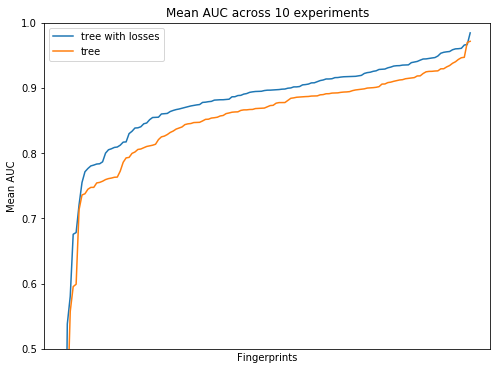

In [27]:
plt.title("Mean AUC across 10 experiments")
plt.plot(range(0, len(exp_mean_auc_scores)), exp_mean_auc_scores, label="tree with losses")
plt.plot(range(0, len(base_mean_auc_scores)), base_mean_auc_scores, label="tree")

plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylabel("Mean AUC")
plt.ylim(0.5, 1.0)
plt.show()

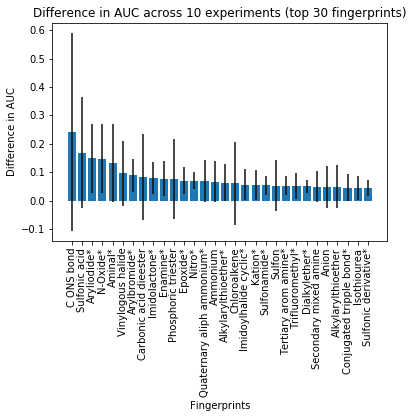

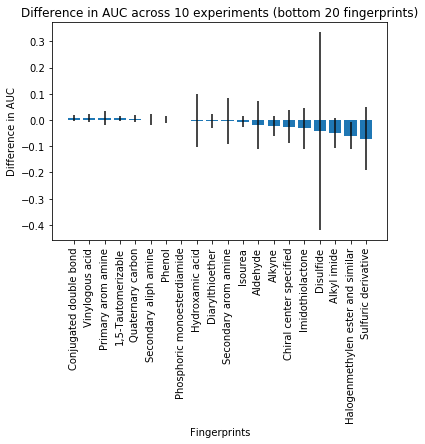

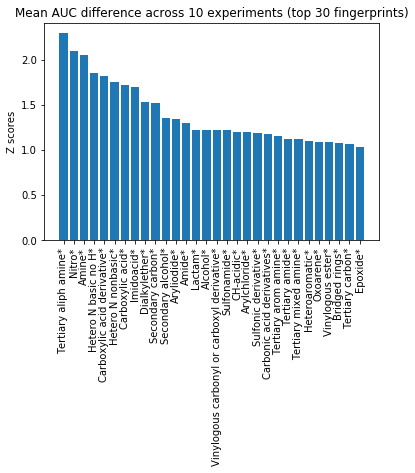

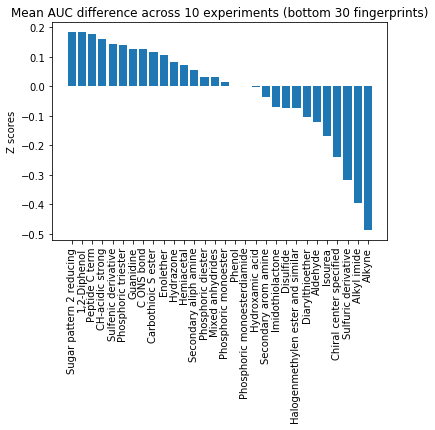

63 significantly different mean aucs
63 significantly positive difference
0 significantly negative difference


In [22]:
error_config = {'ecolor': '0.05'}

plt.title("Difference in AUC across 10 experiments (top 30 fingerprints)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Difference in AUC across 10 experiments (bottom 20 fingerprints)")
plt.bar(fingerprints[119:], score_differences[119:], align='center', yerr=std_err[119:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Mean AUC difference across 10 experiments (top 30 fingerprints)")
plt.bar(z_fingerprints[:30], z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

plt.title("Mean AUC difference across 10 experiments (bottom 30 fingerprints)")
plt.bar(z_fingerprints[109:], z_scores[109:], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in differences if result[1] > 0 and result[0] in stat_significant_fingerprints]
negative_result = [result for result in differences if result[1] < 0 and result[0] in stat_significant_fingerprints]

print("{} significantly different mean aucs".format(max_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))


In [23]:
ranked_f1_pvalues_with_critical_value, max_f1_pvalue_less_than_crit_rank = benjamini_fdr(f1_pvalues)
f1_stat_significant_results = ranked_f1_pvalues_with_critical_value[:max_f1_pvalue_less_than_crit_rank]
f1_stat_significant_fingerprints = [result[0] for result in f1_stat_significant_results]

In [24]:
f1_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints 
                   else fingerprint_names[fingerprint[0]]for fingerprint in f1_differences]
f1_z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints 
                     else fingerprint_names[fingerprint[0]]for fingerprint in f1_z_differences]

f1_score_differences = [f1_score[1] for f1_score in f1_differences]
f1_z_scores = [fingerprint[1] for fingerprint in f1_z_differences]

f1_std_err = [fingerprint[2] for fingerprint in f1_differences]

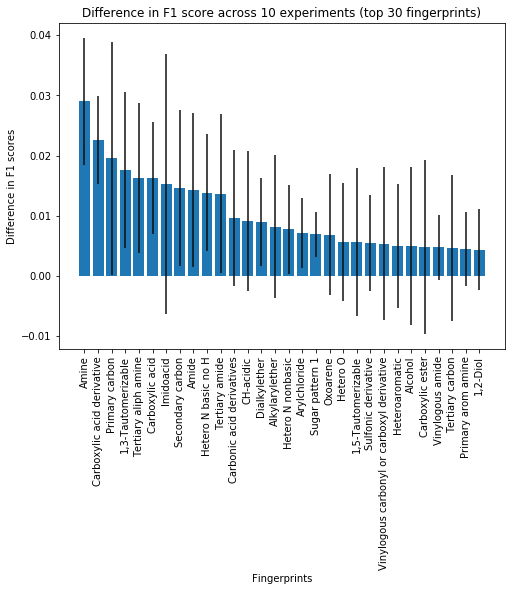

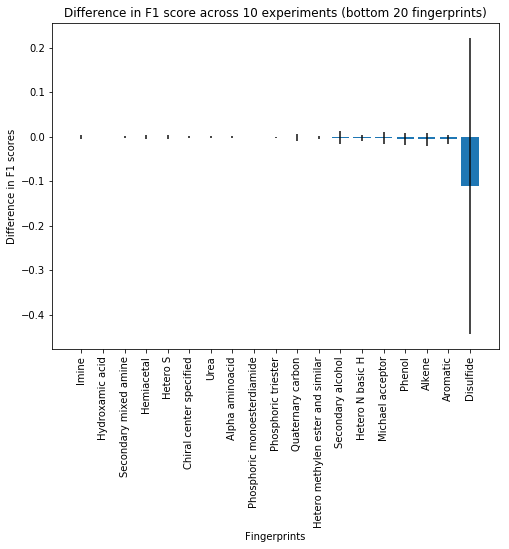

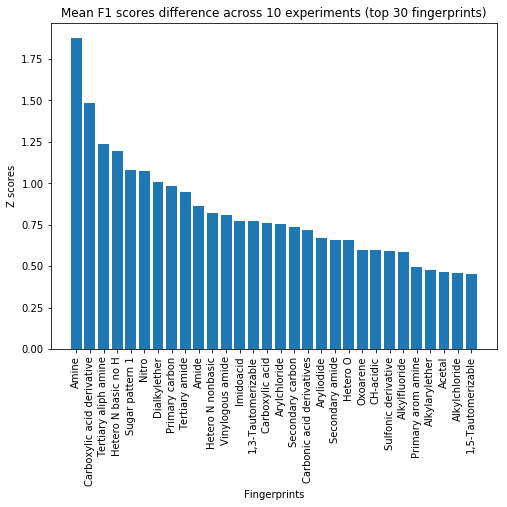

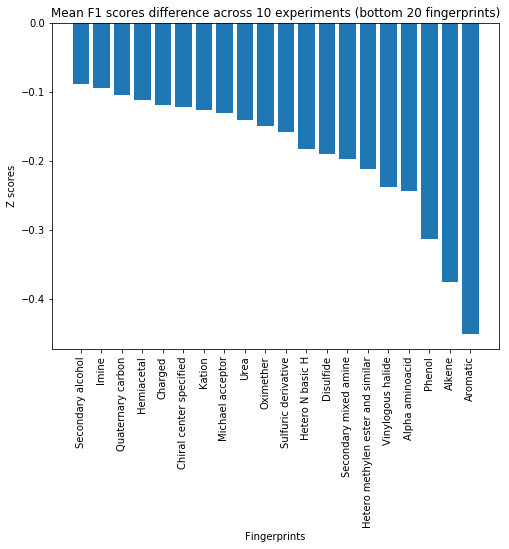

0 significantly different mean f1_scores
0 significantly positive difference
0 significantly negative difference


In [25]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)
plt.title("Difference in F1 score across 10 experiments (top 30 fingerprints)")
plt.bar(f1_fingerprints[:30], f1_score_differences[:30], align='center', yerr=f1_std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Difference in F1 score across 10 experiments (bottom 20 fingerprints)")
plt.bar(f1_fingerprints[120:], f1_score_differences[120:], align='center', yerr=f1_std_err[120:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Mean F1 scores difference across 10 experiments (top 30 fingerprints)")
plt.bar(f1_z_fingerprints[:30], f1_z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores")
plt.show()

plt.title("Mean F1 scores difference across 10 experiments (bottom 20 fingerprints)")
plt.bar(f1_z_fingerprints[119:], f1_z_scores[119:], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in f1_differences if result[1] > 0 and result[0] in f1_stat_significant_fingerprints]
negative_result = [result for result in f1_differences if result[1] < 0 and result[0] in f1_stat_significant_fingerprints]

print("{} significantly different mean f1_scores".format(max_f1_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))